# Análise e Previsão de Séries Temporais (ARIMA)

## Introdução e Análise Inicial

Este projeto consiste na previsão de **Preços de Ações**, utilizando dados históricos de fechamento diário (*Close Price*) de uma gigante da tecnologia.

O *pipeline* envolverá etapas cruciais para a modelagem estatística:

1.  **Análise Exploratória (EDA):** Identificar os componentes da série (Tendência, Sazonalidade, Ruído).
2.  **Estacionariedade:** Testar e transformar a série para torná-la **estacionária** (média e variância constantes ao longo do tempo).
3.  **Modelagem ARIMA:** Determinar os parâmetros $(p, d, q)$ e treinar o modelo **ARIMA (AutoRegressive Integrated Moving Average)**.
4.  **Avaliação e Previsão:** Avaliar o desempenho e gerar previsões futuras.

---

In [1]:
import pandas as pd
import numpy as np

In [5]:
try:
    df = pd.read_csv('../data/big_tech_stock_prices.csv')
    print("Dataset carregado com sucesso!")
except FileNotFoundError:
    print("Erro: O arquivo não foi encontrado. Verifique o caminho do arquivo.")

# Exibir as primeiras linhas do DataFrame
display(df.head())

# Exibindo os valores únicos na coluna 'stock_symbol'
print("Valores únicos na coluna 'stock_symbol':", df['stock_symbol'].unique())

Dataset carregado com sucesso!


,stock_symbol,date,open,high,low,close,adj_close,volume
0,AAPL,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.515213,493729600
1,AAPL,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.526476,601904800
2,AAPL,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.422664,552160000
3,AAPL,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.410790,477131200
4,AAPL,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.453412,447610800


Valores únicos na coluna 'stock_symbol': ['AAPL' 'ADBE' 'AMZN' 'CRM' 'CSCO' 'GOOGL' 'IBM' 'INTC' 'META' 'MSFT'
 'NFLX' 'NVDA' 'ORCL' 'TSLA']


---

O *dataset* contém dados de várias empresas, vamos realizar uma etapa de filtragem para isolar a série temporal de apenas uma delas.

---

In [6]:
# Filtrando dados para uma empresa específica (exemplo: 'AAPL' = Apple Inc.)
df_apple = df[df['stock_symbol']=='AAPL'].copy()

# Selecionando apenas as colunas de interesse (Data e Preço de Fechamento)
df_ts = df_apple[['date', 'close']].copy()

# Convertendo a coluna 'date' para o tipo datetime
df_ts['date'] = pd.to_datetime(df_ts['date'])

# Definindo a coluna 'date' como índice do DataFrame
df_ts.set_index('date', inplace=True)

# Eliminando colunas duplicadas, se houver
df_ts = df_ts[~df_ts.index.duplicated(keep='first')]

# Exibindo informações do DataFrame
print(f"Formato do DataFrame: {df_ts.shape}")
print(f"\nPrimeiras linhas do DataFrame:\n{df_ts.head()}")
print(f"\nTipos de dados:\n{df_ts.dtypes}")

Formato do DataFrame: (3271, 1)

Primeiras linhas do DataFrame:
               close
date                
2010-01-04  7.643214
2010-01-05  7.656429
2010-01-06  7.534643
2010-01-07  7.520714
2010-01-08  7.570714

Tipos de dados:
close    float64
dtype: object


In [14]:
# Verificando valores ausentes
df_ts.isnull().sum()

close    0
dtype: int64

## Decomposição da Série
Antes de partir para a modelagem, vamos visualizar a série para identificar seus componentes: **Tendência**, **Sazonalidade** e **Ruído**. Vamos plotar o gráfico da série temporal completa e aplicar a função `seasonal_decompose` para decompor.

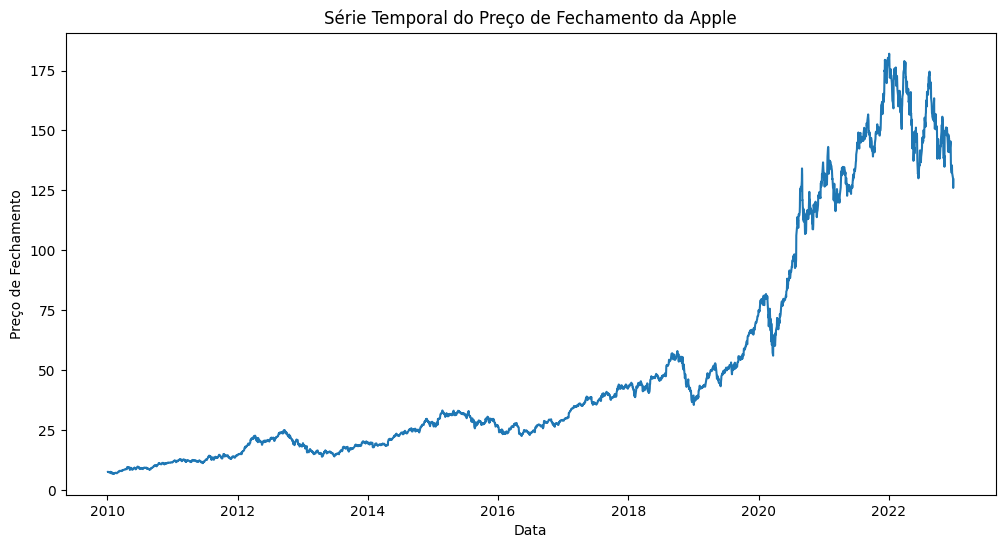

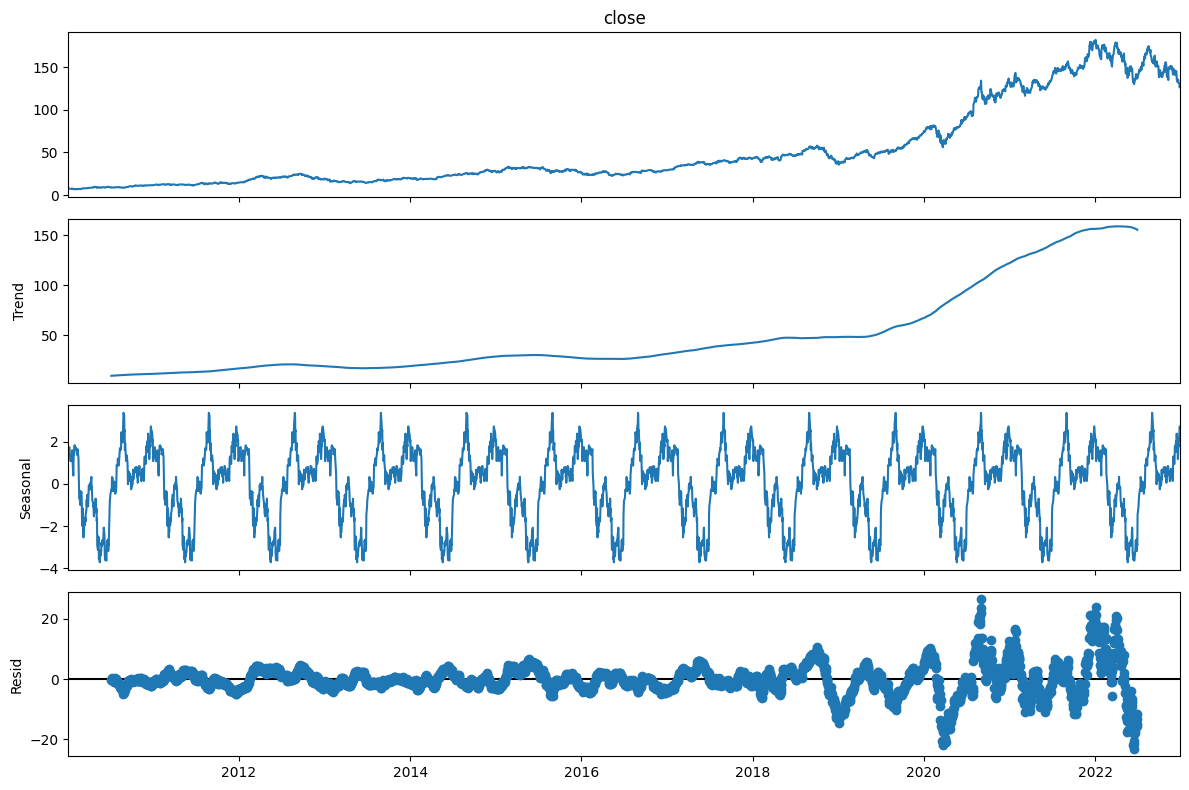

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# Plotando a série temporal
plt.figure(figsize=(12,6))
sns.lineplot(df_ts, x=df_ts.index, y='close')
plt.title('Série Temporal do Preço de Fechamento da Apple')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.show()

# Assumindo frequência anual para dados diários
decomposition = seasonal_decompose(df_ts['close'], model='additive', period=252)

# Plotando os componentes da decomposição
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.tight_layout()
plt.show()

**Análise dos gráficos:**

1. Tendência (*Trend*)
* **Observação**: A série possui uma Tendência forte e clara de crescimento ao longo de todo o período, com um crescimento exponencial notável a partir de $2018$.
* **Implicação**: A presença de tendência crescente significa que a média da série não é constante ao longo do tempo. Portanto, a série é **NÃO-ESTACIONÁRIA**.

2. Sazonalidade (*Seasonal*)
* **Observação**: O componente Sazonal mostra um padrão repetitivo e periódico em ciclos anuais (dado o parâmetro `period=252`). Sugerindo que o preço tem flutuações previsíveis que se repetem a cada ano de negociação.
* **Implicação**: A presença de sazonalidade deve ser tratada no modelo **ARIMA/SARIMA** para que possamos isolar a parte que é realmente aleatória (Ruído).

3. Ruído/Resíduo (*Resid*)
* **Observação**: O componente Ruído é a parte restante da série após remover a Tendência e a Sazonalidade. Nota-se que o ruído aumenta significativamente após 2020.
* **Implicação**: O aumento na variância do ruído ao longo do tempo indica que a volatilidade da série não é constante (a variância não é homogênea), reforçando o diagnóstico de **NÃO-ESTACIONARIDADE**.

---

## Teste de Estacionariedade

Faremos um teste estatístico formal para confirmar a não-estacionariedade: o **Teste de Dickey-Fuller Aumentado (ADF Test)**. Esse teste verifica a hipótese nula ($H_0​$) de que a série **NÃO É ESTACIONÁRIA** (possuindo uma raiz unitária).

In [15]:
from statsmodels.tsa.stattools import adfuller

# Função para realizar o teste ADF
def adf_test(series):
    # Realizando o teste ADF
    result = adfuller(series)

    # Exibindo os resultados
    print(f'Estatística do Teste (ADF): {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    
    # Interpretando o p-value
    if result[1] <= 0.05:
        print("A série é estacionária (rejeitamos H0)")
    else:
        print("A série não é estacionária (não rejeitamos H0)")

# Aplicando o teste ADF na série temporal
adf_test(df_ts['close'])

Estatística do Teste (ADF): -0.2921
p-value: 0.9266
A série não é estacionária (não rejeitamos H0)
